# Computing Shapley Values with `shapiq`
A popular approach to tackle the problem of XAI is to use concepts from _cooperative game theory_.
The most popular method is to use the **Shapley Values** named after Lloyd Shapley, who introduced it in 1951 with his work *"The Value of an n-Person Game"* ([Link](https://www.rand.org/content/dam/rand/pubs/papers/2021/P295.pdf)).

We divide this notebook into _two_ parts.
1. **Introduction to Cooperative Game Theory and Shapley Values:** The _first part_ introduces the mathematical background of cooperative game theory and the Shapley value. It further shows how to use `shapiq` to calculate Shapley values for any cooperative game.

2. **Explainable AI with Shapley Value:** The _second part_ discusses how the to use the `shapiq` library for explainable AI (XAI) with Shapley values.

For practitioners the second part might be most important, but we would highly encourage to read the first part to understand the mathematical implications of Shapley values.

## Introduction to Cooperative Game Theory and Shapley Values
Cooperative game theory deals with the study of games in which players/participants can form groups (also known coalitions) to achieve a collective payoff. More formally a cooperative game is defined as a tuple $(N,\nu)$ where:
- $N$ is a finite set of players
- $\nu$ is a characteristic function that maps every coalition of players to a real number, i.e. $\nu:2^N \rightarrow \mathbb{R}$

### Example: The Cooking Game
To illustrate the concept of cooperative games, we consider a simple example of a _cooking game_ you might find in a restaurant.
The game consists of three cooks, _Alice_, _Bob_, and _Charlie_, who are preparing a meal _together_.

The characteristic function $\nu$ maps each coalition of players to the quality of the meal:
| Coalition             | Quality |
|-----------------------|---------|
| {no cook}             | 0       |
| {Alice}               | 2       |
| {Bob}                 | 3       |
| {Charlie}             | 4       |
| {Alice, Bob}          | 7       |
| {Alice, Charlie}      | 8       |
| {Bob, Charlie}        | 9       |
| {Alice, Bob, Charlie} | 15      |

For example, the coalition {Alice, Bob} has a quality of 7, while the coalition {Alice, Bob, Charlie} has a quality of 15.
If no cooks participate, the quality of the meal is 0 and no meal is prepared.

We can easily model this general form of a cooperative game with `shapiq` by defining a class that inherits from the `shapiq.Game` class.
Note, a game does not necessarily have to be a subclass of `shapiq.Game` and can also be a simple function that defines the value function $\nu:2^N \rightarrow \mathbb{R}$.
Methods in `shapiq` can also be used with such functions. However, using the `Game` class provides a more structured way to define the game and its properties.
It also comes equipped with handy helper methods.

Below we define the `CookingGame` class that models the cooking game.

In [119]:
import numpy as np
import shapiq


class CookingGame(shapiq.Game):
    def __init__(self):
        self.characteristic_function = {
            (): 0,
            (0,): 4,
            (1,): 3,
            (2,): 2,
            (0, 1): 9,
            (0, 2): 8,
            (1, 2): 7,
            (0, 1, 2): 15,
        }
        super().__init__(
            n_players=3,
            player_names=["Alice", "Bob", "Charlie"],  # Optional list of names
            normalization_value=self.characteristic_function[()],  # 0
        )

    def value_function(self, coalitions: np.ndarray) -> np.ndarray:
        """Defines the worth of a coalition as a lookup in the characteristic function."""
        output = []
        for coalition in coalitions:
            output.append(self.characteristic_function[tuple(np.where(coalition)[0])])
        return np.array(output)


cooking_game = CookingGame()
cooking_game

CookingGame(3 players, normalize=False, normalization_value=0, precomputed=False)

We can now use this cooking game to see the quality of the meal for different coalitions:

In [120]:
# query the value function of the game for different coalitions
coals = np.array([[0, 0, 0], [1, 1, 0], [1, 0, 1], [0, 1, 1], [1, 1, 1]])
cooking_game(coals)

array([ 0,  9,  8,  7, 15])

In [121]:
# query the value function with the names of the players
coals = [
    (),
    ("Alice", "Bob"),
    ("Alice", "Charlie"),
    ("Bob", "Charlie"),
    ("Alice", "Bob", "Charlie"),
]
cooking_game(coals)

array([ 0,  9,  8,  7, 15])

In [122]:
# we can automatically get the value of the grand coalition
print("The quality of the meal for the grand coalition is:", cooking_game.grand_coalition_value)

# similarly we can get the value of the empty coalition
print("The quality of the meal for the empty coalition is:", cooking_game.empty_coalition_value)

The quality of the meal for the grand coalition is: 15.0
The quality of the meal for the empty coalition is: 0.0


The chef of the restaurant is now interested in, which cook is the most **talented** one and would like to **distribute a bonus** accordingly.
Of particular interest is to find a concept that _distributes_ the payoff of $\nu(N)$ among the players, as it is assumed that the *grand coalition* $N$ is formed.
The distribution of the payoff among the players is called a *solution concept*.
A fair way to distribute the bonus is to use the Shapley values, which we will discuss in the next section.


### Shapley Values: A Unique Solution Concept

Given a cooperative game $(N,\nu)$, the Shapley value is a payoff vector dividing the total payoff $\nu(N)$ among all relevant players.
The Shapley value of player $i$ is denoted by $\phi_i(\nu)$ and is defined as:
$$
\phi_i(\nu) := \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!(|N|-|S|-1)!}{|N|!} [\nu(S \cup \{i\}) - \nu(S)]
$$.
The Shapley value can be interpreted as the average marginal contribution of player $i$ across all possible permutations/orderings of the players.
Its popularity arises from uniquely satisfies the following properties:
- **Efficiency**: The sum of the Shapley values equals the total payoff, i.e. $\sum_{i \in N} \phi_i(\nu) = \nu(N)$.
This property ensures that the total payoff is distributed among all players. For the cooking game, this means that the total bonus is distributed among the cooks and no bonus is lost.

- **Symmetry**: If two players $i$ and $j$ are such that for all coalitions $S \subseteq N \setminus \{i,j\}$, $\nu(S \cup \{i\}) = \nu(S \cup \{j\})$, then $\phi_i(\nu) = \phi_j(\nu)$.
Symmetry implies that players with equal contributions receive equal payoffs. If two cooks in the cooking game have the same talent, they should receive the same bonus.

- **Additivity**: For a game $(N,\nu + \mu)$ based on two games $(N,\nu)$ and $(N,\mu)$, the Shapley value of the sum of the games is the sum of the Shapley values, i.e. $\phi_i(\nu + \mu) = \phi_i(\nu) + \phi_i(\mu)$.
Through Additivity we gain the possibility of calculating the Shapley value for smaller games and summing them up to receive the Shapley value for the larger game. 
For the cooking game, this means that the chef can calculate the Shapley values for each pair of cooks and sum them up to get the Shapley values for all three cooks.

- **Dummy Player**: If for a player $i$ it holds that for all coalitions $S \subseteq N \setminus \{i\}$, $\nu(S \cup \{i\}) - \nu(S) = \nu(\{i\})$ then $\phi_i(\nu) = \nu(\{i\})$.
Through the Dummy Player property, players that do not contribute at all receive a value of zero.
A cook that does not contribute to the meal preparation should not receive a bonus.

#### Using `shapiq.ExactComputer` to Calculate Shapley Values Exactly

With `shapiq` we can easily calculate the Shapley values for any cooperative game such as the cooking game.
Since the cooking game contains only three players, we will use the `ExactComputer` to calculate the Shapley values exactly.

In [123]:
from shapiq import ExactComputer

# create an ExactComputer object for the cooking game
exact_computer = ExactComputer(n_players=cooking_game.n_players, game_fun=cooking_game)

# compute the Shapley Values for the game
sv_exact = exact_computer(index="SV")
print(sv_exact)

InteractionValues(
    index=SV, max_order=1, min_order=0, estimated=False, estimation_budget=None,
    n_players=3, baseline_value=0.0,
    Top 10 interactions:
        (0,): 6.0
        (1,): 5.0
        (2,): 3.9999999999999996
        (): 0.0
)


With the exact computer we see that the Shapley values for the cooking game are:
- Player 0 (Alice): 6.0
- Player 1 (Bob): 5.0
- Player 2 (Charlie): 4.0

We can also visualize the Shapley values using plots from `shapiq` like the stacked bar plot:

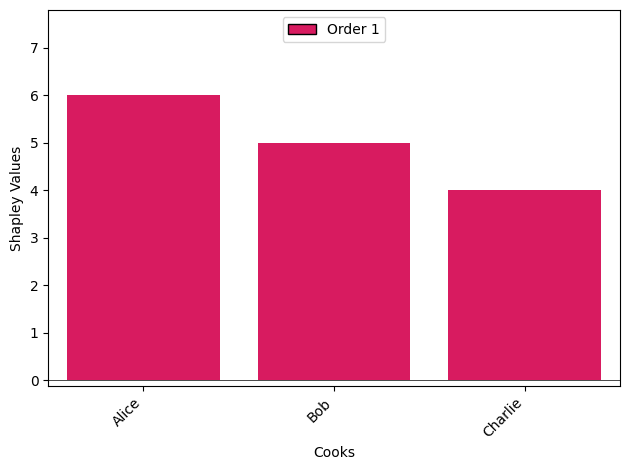

In [124]:
# visualize the Shapley Values
sv_exact.plot_stacked_bar(
    xlabel="Cooks", ylabel="Shapley Values", feature_names=["Alice", "Bob", "Charlie"]
)

Based on the Shapley Values we can interpret, that the total bonus of 15 should be distributed as follows:
- Alice should receive a bonus of 6.0
- Bob should receive a bonus of 5.0
- Charlie should receive a bonus of 4.0

#### Approximating Shapley Values with any Approximation Method
While the exact computation of Shapley values is feasible for small games, it becomes computationally expensive for larger games.
In such cases, we can use approximation methods to estimate the Shapley values.
`shapiq` provides various approximation methods to calculate Shapley values for larger games.
Approximators can be found in the `shapiq.approximator` module.
Here, let's use `shapiq.KernelSHAP` to approximate the Shapley values for the cooking game.

Three players, however, are a bit boring, so let's consider a more interesting Restaurant Game with 10 cooks.

In [125]:
from shapiq import powerset

# create a random number generator with a seed
rng = np.random.default_rng(42)

# food quality is a random number times the number of cooks (more cooks, better quality)
# contrary to the saying "too many cooks spoil the broth"
quality_dict = {cooks: rng.random() * len(cooks) for cooks in powerset(range(10))}


# define the restaurant game as a function
def restaurant_value_function(coalitions: np.ndarray) -> np.ndarray:
    """Defines the worth of a coalition as a lookup in the characteristic function."""
    output = []
    for coalition in coalitions:
        output.append(quality_dict[tuple(np.where(coalition)[0])])
    return np.array(output)


# we can query the value function for different coalitions
cooks_to_check = [
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
]
restaurant_value_function(np.array(cooks_to_check))

array([0.        , 4.73012227, 5.31413812])

The restaurant game is defined as a function `restaurant_value_function` that maps each coalition of cooks to the quality of the meal.
The total payoff of the grand coalition is: 5.31413812

Now let's approximate the Shapley values with KernelSHAP:

InteractionValues(
    index=SV, max_order=1, min_order=0, estimated=True, estimation_budget=100,
    n_players=10, baseline_value=0.0,
    Top 10 interactions:
        (4,): 1.287790373728892
        (7,): 0.9352475133060242
        (6,): 0.729962062803052
        (3,): 0.7097257904661043
        (2,): 0.6497116688567804
        (8,): 0.6355807791292664
        (1,): 0.34334542810807006
        (5,): 0.13950816787183876
        (9,): 0.02633091520392801
        (0,): -0.14306457769455308
)


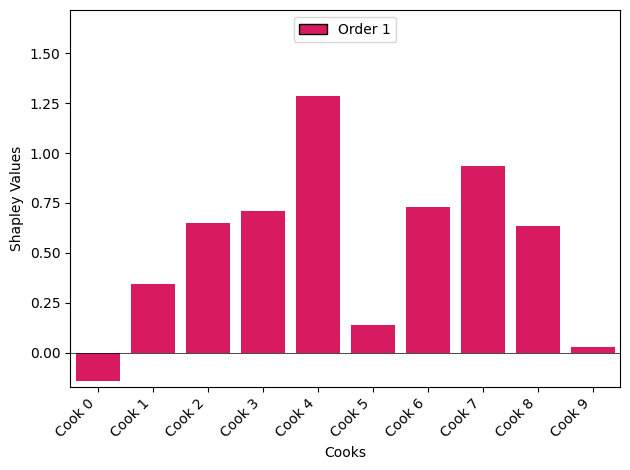

In [126]:
from shapiq import KernelSHAP

# create a KernelSHAP object for 10 players
approx = KernelSHAP(n=10, random_state=42)

# we can now provide the value function to the KernelSHAP and approximate the Shapley values
sv_approx = approx(game=restaurant_value_function, budget=100)
print(sv_approx)

# visualize the Shapley Values
sv_approx.plot_stacked_bar(
    xlabel="Cooks", ylabel="Shapley Values", feature_names=[f"Cook {i}" for i in range(10)]
)

From this, plot we can see that the Shapley value for cook number 4 is the highest, followed by cook 7, etc.

This concludes the first part of the notebook.
In the next part, we will discuss how to use Shapley values for Explainable AI (XAI) with `shapiq`.

## Explainable AI with Shapley Values
In the previous section, we discussed the Shapley values and how to calculate them for cooperative games.
In this section, we will discuss how to use Shapley values for Explainable AI (XAI) with `shapiq`.

### Shapley Values for Local Feature Attribution
In the case of machine learning models and local feature attribution, a cooperative game is usually defined as the tuple $(N,\nu)$ where:

- $N$ is a finite set of features $N = \{1, 2, \ldots, d\}$
- $\nu$ is the output of a model $f$ given a local input $x$ restricted on a subset of features $S \subseteq N$, i.e. $\nu(S) = f_S(x)$

The goal in XAI here is to explain the output of a machine learning provided with access to all feature values $N$ of a data point $x$.
The Shapley values can be used to fairly distribute the output of the model among the features (similarly to the cooks in the cooking game in the previous section).
To do so, the model needs to be evaluated on partial inputs $S \subseteq N$ to determine the contribution of each feature to the model output.

However, naturally, machine learning models operate on a _complete_ feature space $f: \mathcal{X}^d \rightarrow \mathbb{R}$ and not on subsets $S \subseteq N$ of features.
Most machine learning models cannot be evaluated with missing features.
Therefore, we need to define a restricted model $f_S: \mathcal{X}^{|S|} \rightarrow \mathbb{R}$ that operates only on the subset of features $S$.
In practice this is achieved by imputing missing features with values sampled from a background distribution.

Different imputation methods exist and are implemented in `shapiq`:
- `shapiq.BaselineImputer`: Impute missing features with a constant value (e.g. 0) or a summary statistic (e.g. mean/mode).

- `shapiq.MarginalImputer`: Impute missing features $X^{\bar{S}}$ with the marginal feature distribution $X^{\bar{S}} \sim P(X^{\bar{S}})$.

- `shapiq.ConditionalImputer`: Impute missing features $X^{\bar{S}}$ with the conditional feature distribution $X^{\bar{S}} \sim P(X^{\bar{S}}|X^S)$. Note that estimating the conditional distribution can be challenging and often only approximate distributions are used.

To illustrate how to use `shapiq` for XAI, we will first train and evaluate a simple Random Forest model on the California Housing dataset.
Then we will use the Shapley values to explain the model's predictions for a single data point.
Finally, we will visualize the Shapley values to interpret the model's decision.

In [127]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

data, targets = shapiq.datasets.load_california_housing()
feature_names = list(data.columns)
n_features = len(feature_names)
print("Feature names:", feature_names)

# split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(
    data.values, targets.values, test_size=0.2, random_state=42
)

# train a Random Forest model
rf = RandomForestRegressor(n_estimators=10, random_state=42, max_depth=5)
rf.fit(x_train, y_train)

# evaluate the model
test_score = rf.score(x_test, y_test)
print(f"Test R^2 score: {test_score:.4f}")

Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Test R^2 score: 0.6387


The model achieves an $R^2$ score of about 0.80 on the test set.
Let's select a single data point from the test set and explain the model's prediction using the Shapley values.

In [132]:
# select a single data point from the test set
instance_id = 1
x_explain, y_explain = x_test[instance_id], y_test[instance_id]
print("Data point to explain:", x_explain, rf.predict([x_explain]))

approximator = shapiq.SVARM(n=n_features, random_state=42)

# compute the Shapley values for the Random Forest model
explainer = shapiq.TabularExplainer(
    model=rf,
    data=x_test,
    imputer="marginal",
    index="SII",
    max_order=1,
    sample_size=250,
    random_state=42,
    approximator=approximator,
)
sv = explainer.explain(x_explain, budget=2**n_features)
print(sv)

print("Avg prediction:", np.mean(rf.predict(x_test)))

sum(sv.values) + sv.baseline_value

Data point to explain: [ 2.53130000e+00  3.00000000e+01  5.03938356e+00  1.19349315e+00
  1.56500000e+03  2.67979452e+00  3.51400000e+01 -1.19460000e+02] [1.18178858]
InteractionValues(
    index=SV, max_order=1, min_order=0, estimated=False, estimation_budget=256,
    n_players=8, baseline_value=2.054528415045893,
    Top 10 interactions:
        (): 0.018490804319965193
        (1,): 0.004178476797204296
        (7,): 0.0017178973590936293
        (3,): -0.00865637094374197
        (4,): -0.014952508493463409
        (6,): -0.06540199095503717
        (2,): -0.0800085440743866
        (5,): -0.08426495094553842
        (0,): -0.6438426520973053
)
Avg prediction: 2.054528415045893


1.1817885760126834

In [129]:
# tree explainer
explainer = shapiq.TreeExplainer(model=rf, index="SV", max_order=1)

sv = explainer.explain(x_explain)
print(sv)
sum(sv.values)

InteractionValues(
    index=SV, max_order=1, min_order=0, estimated=False, estimation_budget=None,
    n_players=8, baseline_value=2.072184995821221,
    Top 10 interactions:
        (): 2.072184995821221
        (1,): 0.013779191819484265
        (4,): 0.0007988947828769654
        (3,): 0.0006659493330766275
        (7,): -0.018812760324370743
        (6,): -0.04272762048330278
        (5,): -0.07217806936632362
        (2,): -0.1326423036951609
        (0,): -0.6392797018748183
)


1.1817885760126825